# Fitting a Growth Curve Using `BayesFlow`

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
from functools import partial
import bayesflow as bf
import pandas as pd
from utils import matplotlib_style
cor, pal = matplotlib_style()

/Users/gchure/Dropbox/git/postdoc_projects/scrappy/.venv/lib/python3.10/site-packages/bayesflow/trainers.py:27: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


To learn how to use BayesFlow and amortized inference in general, I'm going to operate 
on a simple model of a bacterial growth curve. The model is a simple exponential growth model, 
where the growth rate is a function of the current population size (measured in 
arbitrary optical density units) and has the form
$$
M(t) = M_0 \exp(\lambda t) \tag{1}
$$
where $M$ is the optical density, $M_0$ is the initial biomass of the system,
$t$ is time, and $\lambda$ is the growth rate with units of inverse time. As M 
is a strictly positive quantity, this can be rewritten as a simple linear model 
$$
\widehat{M}(t) = \widehat{M_0} + \lambda t, \tag{2}
$$
where $\widehat{M_0} = \log(M_0)$ and $\widehat{M}(t) = \log(M(t))$.

## Bayesian Model
We want to infer the intercept $\widehat{M_0}$ and the growth rate $\lambda$
from time-resolved measurements of the log $\widehat{M}$. We will assume 
that the measurement noise is Gaussian with a standard deviation $\sigma$, meaning 
that $\widehat{M}(t)$ is distributed as
$$
f(\widehat{M}\,\vert\, \widehat{M_O}, \lambda, \sigma) \sim \mathcal{N}( \widehat{M_0} + \lambda t, \sigma). \tag{3}
$$
where $f$ denotes a probability density over data.

We will assume zero-mean half-normal priors for all of the parameters,
$$
g(M_0) \sim \mathcal{HN}(0, 0.1), \tag{4}
$$
$$
g(\lambda) \sim \mathcal{HN}(0, 1), \tag{5}
$$
$$
g(\sigma) \sim \mathcal{HN}(0, 0.1), \tag{6}
$$
where $g$ denotes probability density over parameteres and the choices for the 
scale parameter for the priors based on domain expertise (e.g., maximal $\lambda$ is probably ≈ 3 per hour and most likely less,
the initial biomass is small).

Using BayesFlow, we define these priors as `Prior` objects from which random samples are drawn

In [2]:
# Set the random number generator to be used
RNG = np.random.default_rng()

#Define the prior function and load it as a Prior object
def prior_fn():
    """
    Defines the joint prior distributison over M_0, labmda, and sigma
    """
    M_0 = np.abs(RNG.normal(0, 0.1))
    lam = np.abs(RNG.normal(0, 1))
    sigma = np.abs(RNG.normal(0, 0.25))
    return np.array([M_0, lam, sigma])
prior = bf.simulation.Prior(prior_fun=prior_fn, param_names=[r'$M_O$', '$\lambda$', '$\sigma$'])

With the prior defined, we can now draw samples from them!

In [3]:
# Draw 10 samples from the joint prior
prior(10)

{'prior_draws': array([[0.05141397, 0.6069875 , 0.15665586],
        [0.01851136, 0.07337512, 0.19500904],
        [0.01494988, 1.9044433 , 0.30771286],
        [0.09274387, 1.56529839, 0.08675511],
        [0.06159016, 0.44956238, 0.36680833],
        [0.09276602, 0.37037267, 0.33328778],
        [0.1041117 , 0.2849286 , 0.18714929],
        [0.01684373, 0.14315023, 0.30314288],
        [0.22938511, 0.54987394, 0.16226796],
        [0.117894  , 1.11533438, 0.12895139]]),
 'batchable_context': None,
 'non_batchable_context': None}

Here, `batchable_context`, and `non_batchable_context` relate to which 
parameters are allowed to vary between and within simulations.

We can now define the likelihood as a function of the parameters and the time dimension.

In [4]:
# Define the likelihood function
def likelihood_fn(params, timepoints ):
    # Unpack parameters
    M_0, lam, sigma = params

    # Compute the likelihood mean
    mu = np.log(M_0)+ lam * timepoints
    return RNG.normal(mu, sigma, size=(params.shape[0], len(timepoints)))

timepoints = np.linspace(0, 5, 10)
simulator = bf.simulation.Simulator(simulator_fun=partial(likelihood_fn, 
                                                          timepoints=timepoints))

With the likelihood simulator and the priors defined, we can assemble the 
generative model. With this in place, we draw samples and generate new data. 
Let's draw 100 samples and plot them

INFO:root:Performing 2 pilot runs with the anonymous model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 3)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 3, 10)
INFO:root:No optional prior non-batchable context provided.
INFO:root:No optional prior batchable context provided.
INFO:root:No optional simulation non-batchable context provided.
INFO:root:No optional simulation batchable context provided.


Text(0, 0.5, 'biomass [a.u.]')

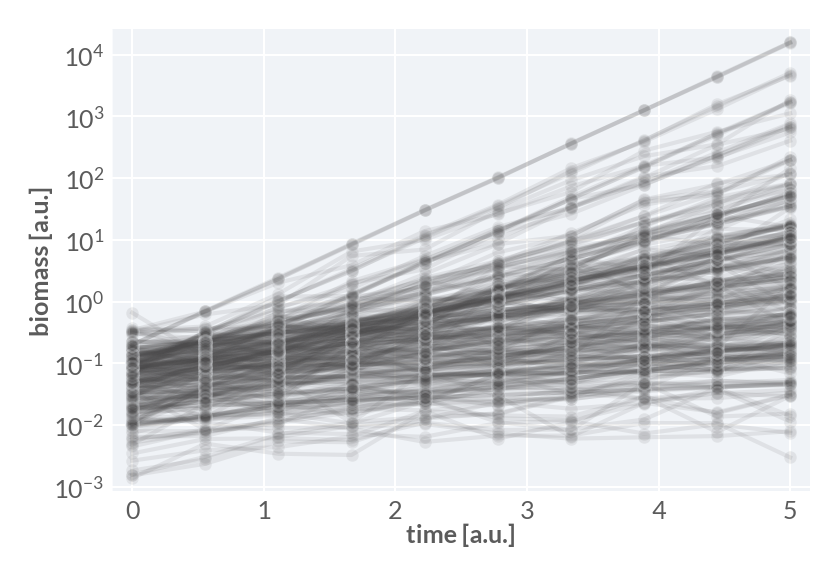

In [5]:
# Build the generative model 
model = bf.simulation.GenerativeModel(prior, simulator)

# Draw 100 samples from the prior, and simulate the growth curves (total 300) 
n_sims = 100
model_draws = model(n_sims)
fig, ax = plt.subplots(1,1, figsize=(3, 2))
time_range = np.linspace(0, 5, 10)
for i in range(n_sims):
    for j in range(3):
        ax.plot(time_range, np.exp(model_draws['sim_data'][i, j, :]),
                '-', marker='.', color=cor['primary_black'], lw=1, alpha=0.1)
ax.set_yscale('log')
ax.set_xlabel('time [a.u.]', fontsize=6)
ax.set_ylabel('biomass [a.u.]', fontsize=6)

This matches kind of what we would expect from a bacterial growth curve with a 
wide range of rates. We can plot draws from the prior to see the ranges they 
yield 

INFO:matplotlib.mathtext:Substituting symbol \lambda from STIXNonUnicode
INFO:matplotlib.mathtext:Substituting symbol \sigma from STIXNonUnicode
INFO:matplotlib.mathtext:Substituting symbol \lambda from STIXNonUnicode
INFO:matplotlib.mathtext:Substituting symbol \sigma from STIXNonUnicode


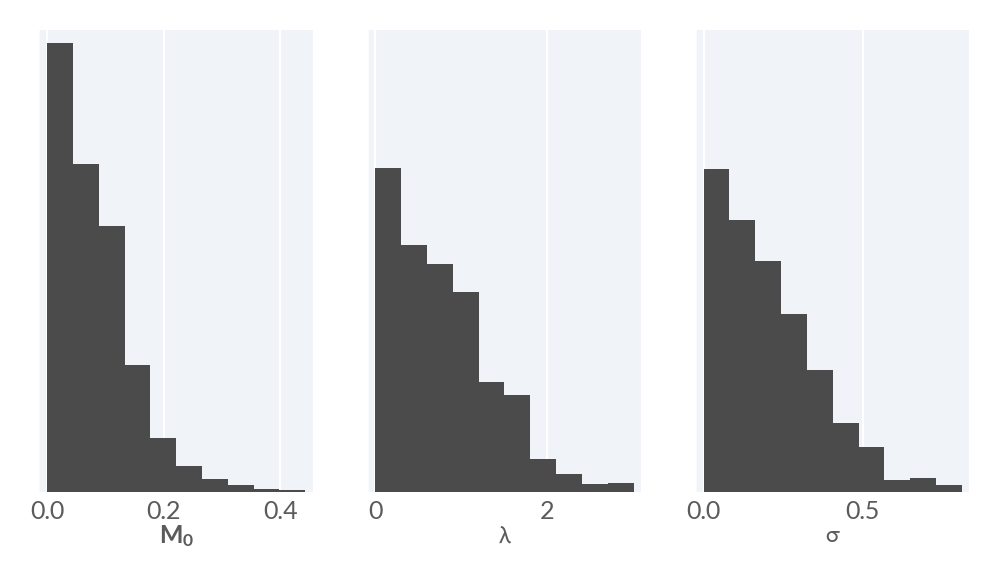

In [6]:
draws = prior(1000)
M_0 = draws['prior_draws'][:, 0]
lam = draws['prior_draws'][:, 1]
sigma = draws['prior_draws'][:, 2]

# Set the figure canvas and configure
fig, ax = plt.subplots(1, 3, figsize=(4, 2), sharey=True)
for a in ax:
    a.set_yticks([])
ax[0].set_xlabel(r'$M_0$', fontsize=6)
ax[1].set_xlabel(r'$\lambda$', fontsize=6)
ax[2].set_xlabel(r'$\sigma$', fontsize=6)

# Plot the distributions
_ = ax[0].hist(M_0, color=cor['primary_black'])
_ = ax[1].hist(lam, color=cor['primary_black'])
_ = ax[2].hist(sigma, color=cor['primary_black'])

These make sense, and the range of values are plausible given my domain expertise 
in measuring this stuff. 

## Building the Neural Approximator

With the Bayesian generative model in place, we can now turn to crafting the 
cINN that will learn to invert the generative model. We first need to define 
a summary network that will compress an input of arbitrary length to a standard 
set of learned summary statistics, which will then pass into the inference network 
which will approximate the posterior distribution using normalizing flows. 


Note that in this case, the data are not exchangeable, as the simulated values 
are dependent on the time dimension. This means that we need to use a summary 
network that respects the time dimension, like a transformer architecture. BayesFlow 
has a built-in transformer architecture that we can use for this purpose. 

In [41]:
# Set up the summary network.
input_dim = model_draws['sim_data'].shape[-1]
summary_net = bf.summary_networks.TimeSeriesTransformer(input_dim=input_dim, 
                                                         summary_dim=10)
                                                         
# summary_net = bf.summary_networks.DeepSet()
# Simulate a pass through the network to see the embedding
test_input = model(1)
summary_pass = summary_net(test_input['sim_data']).numpy()
summary_pass

array([[-0.355011  ,  0.5306377 ,  1.739321  ,  1.4893203 ,  1.6374798 ,
         0.596195  ,  0.5568261 ,  0.6851365 ,  0.21492672, -1.3460332 ]],
      dtype=float32)

We can now define the inference network. This one is easy and must be an 
invertible neural network. We will use the default settings for this as 
this is a very simple application of BayesFlow, but there are a number of 
hyperparameters we could toy with.



In [36]:
# Define the cINN
inference_net = bf.inference_networks.InvertibleNetwork(num_params=3,
                                                        num_coupling_layers=4,
                                                        coupling_settings={"dense_args": dict(kernel_regularizer=None), "dropout": False})

# Perform a forward pass through the network given the summary network embedding
z, log_det_J = inference_net(test_input['prior_draws'], summary_pass)
print(f"Latent variables: {z.numpy()}")
print(f"Log Jacobian Determinant: {log_det_J.numpy()}")

Latent variables: [[0.13479573 1.9886752  0.09053543]]
Log Jacobian Determinant: [0.]


Here, the "latent variables" represent the embedding of the parameter values and 
the log determinant of the Jacobian represents the total magnitude of their 
transformation.


### Training the Neural Approximator
With the generative model, the summary network, and the inference network defined, 
we have a complete specification. We can now train the weights of the neural networks 
to recover the prior parameters given data produced by the `Simulator`. We 
do so by stitching together the neural networks as an `Amortizer` 

In [43]:
# Assemble the amoratizer and teh trainer
amortizer = bf.amortizers.AmortizedPosterior(inference_net, summary_net)
trainer = bf.trainers.Trainer(amortizer=amortizer, generative_model=model)

INFO:root:Performing a consistency check with provided components...
INFO:root:Done.


Since this isn't a ridiculous model, we can do the learning online. To test this, 
we can run a pass through the trainer and get a measure of the time requirements

In [44]:
%%time
_ = model(100)


CPU times: user 2.37 ms, sys: 1.22 ms, total: 3.59 ms
Wall time: 2.83 ms


This is pretty fast -- only 3.27 ms total to run a pass through the network for
100 simulations. Let's train it!

### Assembling the Generative Model
We can now stitch together the `Prior` object and the `Simulator` to create a 
generative model

In [52]:
trainer = bf.trainers.Trainer(amortizer=amortizer, generative_model=model)
history = trainer.train_online(epochs=5, iterations_per_epoch=1000,  batch_size=32)

INFO:root:Performing a consistency check with provided components...
INFO:root:Done.
Training epoch 5: 100%|██████████| 1000/1000 [00:11<00:00, 90.44it/s, Epoch: 5, Iter: 1000,Loss: -9.414,Avg.Loss: -9.647,LR: 4.47E-11]


To see how well it worked, we can plot the training loss as a function of the 
training step. 

Text(0, 0.5, 'training loss')

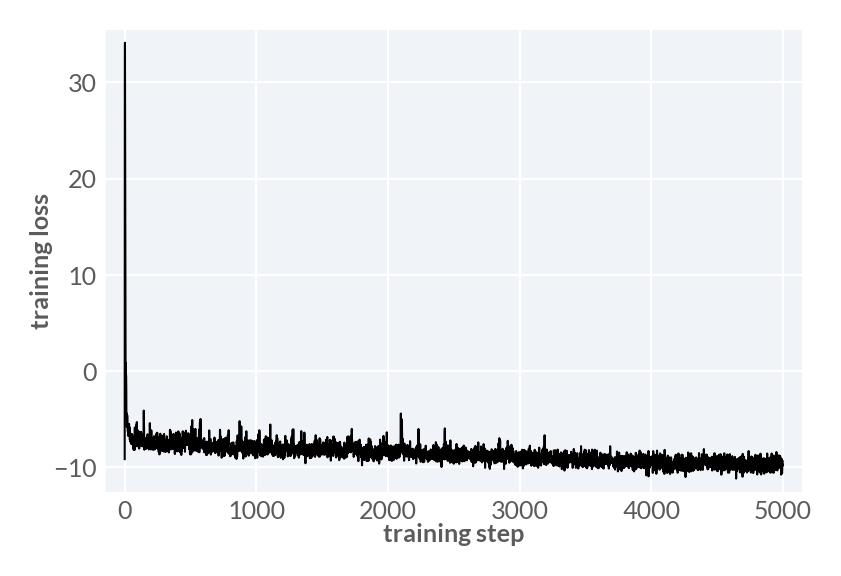

In [55]:
# Plot the training history
fig, ax = plt.subplots(1, 1, figsize=(3,2))
ax.plot(history['Default.Loss'], 'k-')
ax.set_xlabel('training step', fontsize=6)
ax.set_ylabel('training loss', fontsize=6)

In [50]:
history

{'train_losses':       Default.Loss
 0        14.603046
 1         6.377635
 2         3.267126
 3         1.367627
 4         0.575690
 ...            ...
 2995     -9.172637
 2996     -8.649338
 2997     -9.663148
 2998     -8.119274
 2999     -9.187765
 
 [3000 rows x 1 columns],
 'val_losses':    Default.Loss
 0     -2.931484
 1     -8.279911
 2     -9.088227}

To see how well the training worked, we can use the BayesFlow builtin `plot_losses`
function.

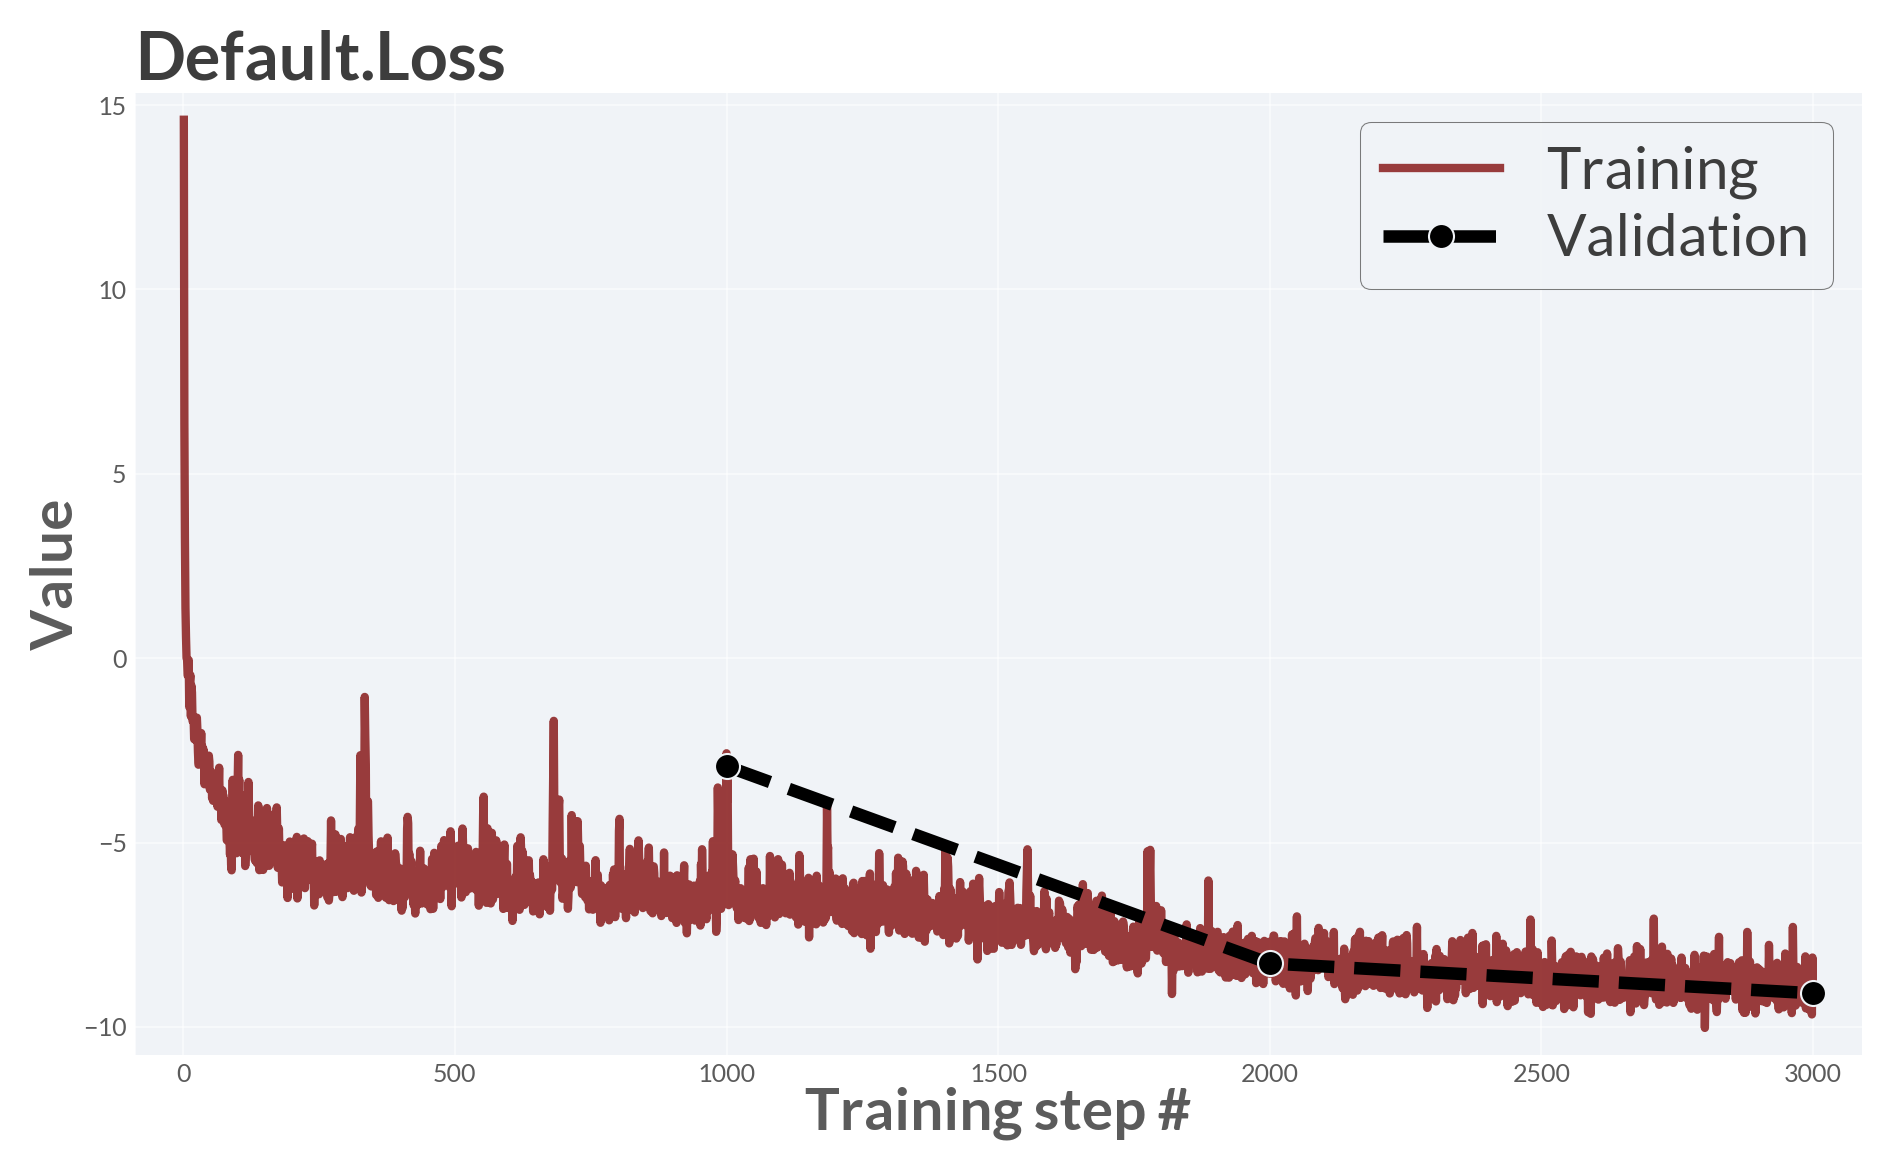

In [46]:
fig = bf.diagnostics.plot_losses(history["train_losses"], history["val_losses"], moving_average=True)
ax = fig.get_axes()
# ax[0].set_yscale('log')
fig.set_figwidth(6)
fig.set_figheight(4)


In [47]:
history

{'train_losses':       Default.Loss
 0        14.603046
 1         6.377635
 2         3.267126
 3         1.367627
 4         0.575690
 ...            ...
 2995     -9.172637
 2996     -8.649338
 2997     -9.663148
 2998     -8.119274
 2999     -9.187765
 
 [3000 rows x 1 columns],
 'val_losses':    Default.Loss
 0     -2.931484
 1     -8.279911
 2     -9.088227}